# Think Bayes: Chapter 3

This notebook presents example code and exercise solutions for Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

## Exercises

**Exercise:** To write a likelihood function for the locomotive problem, we had
to answer this question:  "If the railroad has `N` locomotives, what
is the probability that we see number 60?"

The answer depends on what sampling process we use when we observe the
locomotive.  In this chapter, I resolved the ambiguity by specifying
that there is only one train-operating company (or only one that we
care about).

But suppose instead that there are many companies with different
numbers of trains.  And suppose that you are equally likely to see any
train operated by any company.
In that case, the likelihood function is different because you
are more likely to see a train operated by a large company.

As an exercise, implement the likelihood function for this variation
of the locomotive problem, and compare the results.

** Solution **

So to start, it'll be helpful to make explicit what I am trying to find. I want to find the number of trains operated by a specific company when I have observed one of their locomotives, and its number. However, there are many locomotive companies operating trains. 

Previously, my likelihood function $L(D|H)$ was $\frac{1}{N}$ if the train number observed (the data D) is smaller than N, and 0 otherwise (since a company with $N=20$ trains has 0 probability of having a train numbered 60).

Now, my likelihood function consists of two probabilities:
* The probability that I will see a train labelled D from my company, given my hypotheses H
* The probability that I will see *any* train run by this company

Since $P(A, B) = P(A)P(B)$, I can just multiply them together to get the likelihood.

What is the likelihood I will see *any* train run by this company? Assuming uniform distributions, this will be $\frac{N}{\textrm{Total number of trains}}$. Let's define T, the total number of other trains. Then, this likelihood becomes $\frac{N}{\textrm{N+T}}$. Then, I can define my likelihood function,


$ L(D | H) = (\frac{N}{N+T} \times \frac{1}{N}) \textrm{ if N $\geq$ D else 0} $

I can express this in a `Pmf` object.

In [29]:
class GeneralTrains(Pmf):
    """Map from a company size N to a probability"""
    def __init__(self, hypos):
        """Initialize the distribution.

        hypos: sequence of hypotheses
        """
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1/hypo)
        self.Normalize()

    def Update(self, data, T):
        """Updates each hypothesis based on the data.

        data: any representation of the data
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo, T)
            self.Mult(hypo, like)
        self.Normalize()
    
    def Likelihood(self, data, hypo, T):
        """Compute the likelihood of the data under the hypothesis.

        hypo: integer company size
        data: integer label of the train observed
        """
        if hypo < data:
            return 0
        else:
            return (1/hypo)*(hypo/(hypo+T))

Now, I can run this for different values of T

In [31]:
T = 100000

In [32]:
general_train = GeneralTrains(hypos=range(1, 1001))
general_train.Update(60, T)

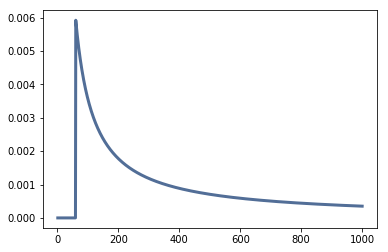

In [33]:
thinkplot.Pdf(general_train)

In [46]:
T = 10

In [47]:
general_train = GeneralTrains(hypos=range(1, 1001))
general_train.Update(60, 100)

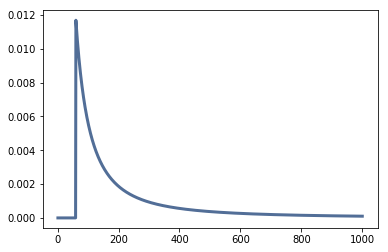

In [48]:
thinkplot.Pdf(general_train)

Interestingly, this seems to converge for very large values of `T` to the case where we assume a uniform prior of N, and for small values of N to the case where we assume the power law (as expected).

**Exercise:** Suppose I capture and tag 10 rock hyraxes.  Some time later, I capture another 10 hyraxes and find that two of them are already tagged.  How many hyraxes are there in this environment?

As always with problems like this, we have to make some modeling assumptions. 

1) For simplicity, you can assume that the environment is reasonably isolated, so the number of hyraxes does not change between observations.

2) And you can assume that each hyrax is equally likely to be captured during each phase of the experiment, regardless of whether it has been tagged.  In reality, it is possible that tagged animals would avoid traps in the future, or possible that the same behavior that got them caught the first time makes them more likely to be caught again.  But let's start simple.

I suggest the following notation:

*  `N`: total population of hyraxes 
*  `K`: number of hyraxes tagged in the first round 
*  `n`: number of hyraxes caught in the second round
*  `k`: number of hyraxes in the second round that had been tagged

So `N` is the hypothesis and `(K, n, k)` make up the data.  The probability of the data, given the hypothesis, is the probability of finding `k` tagged hyraxes out of `n` if (in the population) `K` out of `N` are tagged. 

If you are familiar with the hypergeometric distribution, you can use the hypergeometric PMF to compute the likelihood function.  Otherwise, you can figure it out using combinatorics.

**Solution**

As with the locomotive example, my hypotheses are going to be some range of N. My data is going to be that I saw `k` tagged hydraxes, where I know K are tagged.

To solve this, I can use [combinations](https://www.mathsisfun.com/combinatorics/combinations-permutations.html) (the hint was 'combinatorics'). 

What I am solving for is a combination without repetition (since the same tagged hydrax can't be in multiple traps). First, lets consider how many total different ways there are of catching the hydraxes. I am choosing `n` out of `N` of them, so this is easy: $\frac{N!}{n!(N-n)!}$.

Out of these $\frac{N!}{n!(N-n)!}$ ways, how many of them will yield `k` already tagged Hydraxes?

If in my sample of `n` hydraxes, `k` have been tagged, then that means `n-k` have not been tagged. 

This means there are two samplings happening here; my sampling of tagged hydraxes, and untagged ones (and each of these samplings are independent, so I can multiply them together).

For my tagged hydraxes, I have chosen `k` from `K`, or $\frac{K!}{k!(K-k)!}$

For my untagged hydraxes, I have chosen `n-k` from `N-K`, or $\frac{(N-K)!}{(n-k)!(N-K)!}$

Multiplying them together yields $\frac{K!}{k!(K-k)!} \frac{(N-K)!}{((n-k)!(N-K-n+k)!}$.

In [73]:
from math import factorial as fac

In [74]:
class Hydrax(Pmf):
    """Map from a population size N to a probability"""
    def __init__(self, hypos):
        """Initialize the distribution.

        hypos: sequence of hypotheses
        """
        Pmf.__init__(self)
        for hypo in hypos:
            # note: populations of animals
            # probably don't follow a power law,
            # so I'll change this back to a uniform
            # distribution
            self.Set(hypo, 1)
        self.Normalize()

    def Update(self, k, n, K):
        """Updates each hypothesis based on the data.

        data: any representation of the data
        """
        for hypo in self.Values():
            like = self.Likelihood(hypo, k, n, K)
            self.Mult(hypo, like)
        self.Normalize()
    
    def Likelihood(self, hypo, k, n, K):
        """Compute the likelihood of the data under the hypothesis.

        hypo: integer population size
        data: integer label of the train observed
        """
        if hypo < (K + (n-k)):
            return 0
        else:
            normalizing = fac(hypo) / (fac(n)*fac(hypo-n))
            sampling_tagged = fac(K) / (fac(k)*(fac(K-k)))
            sampling_untagged = fac(hypo-K) / (fac(n-k)*fac(hypo-K-n+k))
        return (sampling_tagged*sampling_untagged) / normalizing

In [75]:
hydrax = Hydrax(hypos = range(1, 1001))
hydrax.Update(k=2, K=10, n=10)

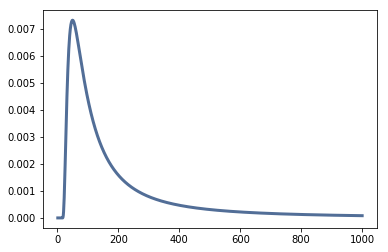

In [76]:
thinkplot.Pdf(hydrax)

I can find the mean of this distribution

In [77]:
hydrax.Mean()

185.63813036305478

and the confidence intervals

In [78]:
hydrax.Percentile(5), hydrax.Percentile(95)

(36, 618)